In [2]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
from spyglass.common import Session, IntervalList, Electrode, get_electrode_indices, interval_list_contains, interval_list_intersect
from spyglass.lfp.v1 import LFPV1
# from spyglass.lfp_band.v1 import LFPBandV1
from spyglass.position import PositionOutput
from spyglass.position.v1 import TrodesPosV1
from tqdm import tqdm

import os
os.chdir('/home/sambray/Documents/MS_analysis_samsplaying/')
from ms_opto_stim_protocol import OptoStimProtocol,OptoStimProtocolParams, OptoStimProtocolTransfected, OptoStimProtocolLaser, OptoStimProtocolClosedLoop
from Analysis.utils import filter_animal, filter_task, filter_opto_data
from Analysis.lfp_analysis import get_ref_electrode_index, power_spectrum
from Analysis.position_analysis import filter_position_ports
from Style.style_guide import transfection_style


os.chdir('/home/sambray/Documents/MS_analysis/')
from ms_task_performance import AlternationTaskPerformance
from ms_dio_event import DioEvents, ProcessedDioEvents

from ms_task_identification import TaskIdentification
from ms_interval import EpochIntervalListName

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get the Data

In [3]:
track_type = "early_wtrack"
inbound_trial = []
trial_velocities = []
opto_trial = []
transfected_trial = []
accuracy = []
animal = ""


#################################
for transfected in [True, False]:
    dataset_key = {
        # 'pulse_length_ms':40,
        # "transfected":True,
        "laser_power": 77,
        "targeted_phase": 90,
        "animal": animal,
        "transfected": transfected,
        "track_type": track_type,
        # "interval_list_name":"pos 3 valid times",
    }
    dataset = filter_opto_data(dataset_key)

    for nwb_file_name, interval_name in tqdm(
        zip(dataset.fetch("nwb_file_name"), dataset.fetch("interval_list_name"))
    ):
        if (
            nwb_file_name == "Bilbo20230802_.nwb"
            and interval_name == "pos 13 valid times"
        ):
            continue
        key = {
            "nwb_file_name": nwb_file_name,
            "interval_list_name": interval_name,
        }
        # outcomes and durations
        outcomes = ((AlternationTaskPerformance() * EpochIntervalListName) & key).fetch(
            "performance_outcomes"
        )
        if not len(outcomes):
            continue
        outcomes = outcomes[0]
        poke_times = (
            (ProcessedDioEvents().FirstUpPokes() * EpochIntervalListName) & key
        ).fetch1("dio_first_poke_times")
        last_poke_times = (
            (ProcessedDioEvents().LastDownPokes() * EpochIntervalListName) & key
        ).fetch1("dio_last_poke_times")
        inbound_trial.extend([("inbound" in x) for x in outcomes[1:]])
        accuracy.extend([("incorrect" in x) for x in outcomes[1:]])

        # speed
        pos_df = (
            TrodesPosV1() & key & {"trodes_pos_params_name": "single_led"}
        ).fetch1_dataframe()
        timestamps = np.array(pos_df.index)
        speed = np.asarray(pos_df.speed)
        trial_intervals = [
            [poke_times[i], poke_times[i + 1]] for i in range(len(poke_times) - 1)
        ]
        travel_intervals = np.array(filter_position_ports(key))
        for trial in trial_intervals:
            intervals = interval_list_intersect(
                np.array(trial)[None, :], travel_intervals
            )
            if not len(intervals):
                trial_velocities.append(np.array([]))
                continue
            trial_velocities.append(
                np.concatenate(
                    [
                        speed[
                            np.where(
                                (timestamps > interval[0]) & (timestamps < interval[1])
                            )[0]
                        ]
                        for interval in intervals
                    ]
                )
            )

        # Dio intervals
        test_intervals = (OptoStimProtocol() & key).fetch1("test_intervals")
        opto_trial.extend(
            [
                interval_list_contains(test_intervals, np.array([i])).size
                for i in poke_times[1:]
            ]
        )

        # transfected
        transfected_trial.extend(np.ones(outcomes.size - 1) * int(transfected))

# trial_durations = np.array(trial_durations)
inbound_trial = np.array(inbound_trial)
opto_trial = np.array(opto_trial).astype(bool)
transfected_trial = np.array(transfected_trial).astype(bool)
accuracy = ~np.array(accuracy).astype(bool)

datasets: 44


44it [00:57,  1.31s/it]


datasets: 42


42it [00:55,  1.33s/it]


## Plot Version 1

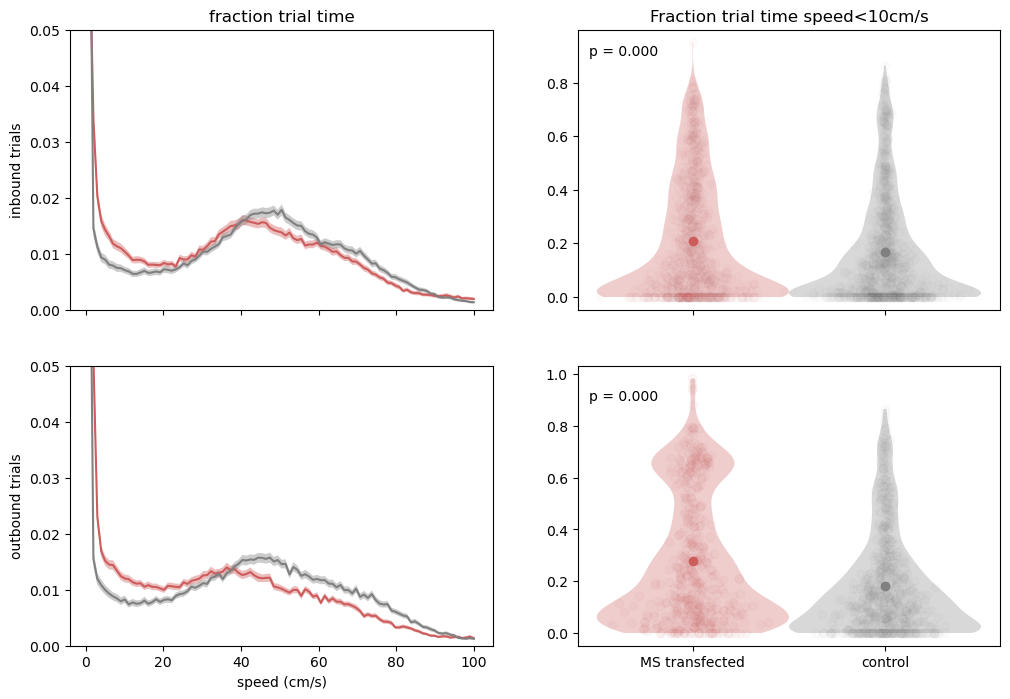

In [4]:
from Analysis.utils import violin_scatter
from scipy.stats import ttest_ind

root_condition = (opto_trial) + ~opto_trial  # & ~inbound_trial
root_condition = [True for _ in opto_trial]
root_condition = accuracy
speed_thresh = 10
pause_time = 30

fig, ax_list = plt.subplots(ncols=2, nrows=2, figsize=(12, 8), sharex="col")
dur_stationary_list = []
for ii, trial_type in enumerate([inbound_trial, ~inbound_trial]):
    base_condition = root_condition & trial_type
    ax = ax_list[ii]
    stationary_list = []
    for i, (filter, color) in enumerate(
        zip([transfected_trial, ~transfected_trial], transfection_style.values())
    ):
        condition = base_condition & filter
        dist = []
        dur_stationary = []
        # for velocity in np.array(trial_velocities)[np.where(condition)[0]]:
        for ii in np.where(condition)[0]:
            velocity = np.array(trial_velocities[ii])
            velocity = velocity[~np.isnan(velocity)]
            val, bins = np.histogram(velocity, bins=np.linspace(0, 100, 100))
            if not val.sum():
                continue
            val = val / val.sum()
            dist.append(val)
            dur_stationary.append((velocity < speed_thresh).sum())
        dur_stationary_list.append(np.array(dur_stationary))
        dist = np.array(dist)
        # ax[0].plot(bins[1:],np.mean(dist,axis=0),c=color)
        # ax[0].fill_between(bins[1:],np.nanpercentile(dist,25,axis=0),np.nanpercentile(dist,75,axis=0),facecolor=color,alpha=.4)
        # c.i plot
        from Analysis.utils import bootstrap_traces

        yy, rng = bootstrap_traces(dist, 1000)
        ax[0].plot(bins[1:], yy, c=color)
        ax[0].fill_between(bins[1:], *rng, facecolor=color, alpha=0.4)

        # stationary time
        ind_stationary = np.where(bins < speed_thresh)[0]

        stationary_fract = np.nansum(dist[:, ind_stationary], axis=1)
        stationary_list.append(stationary_fract)

        violin_scatter(
            stationary_fract, pos=i / 2, ax=ax[1], color=color, bw_method=0.2
        )
        # violin = ax[1].violinplot(stationary_fract,positions=[i/2],
        #            showmedians=False,showextrema=False,points=1000,)
        # for pc in violin['bodies']:
        #     pc.set_facecolor(color)
        #     pc.set_alpha(.5)
        ax[1].scatter(
            [i / 2],
            np.mean(stationary_fract),
            color=color,
        )
        # break
    p_val = ttest_ind(stationary_list[0], stationary_list[1])[1]
    ax[1].text(-0.27, 0.9, f"p = {p_val:.3f}")
ax_list[
    0,
    0,
].set_ylim(0, 0.05)
ax_list[
    1,
    0,
].set_ylim(0, 0.05)
ax[0].set_xlabel("speed (cm/s)")
ax_list[0, 0].set_title("fraction trial time")
ax[1].set_xticks([0.0, 0.5])
ax[1].set_xticklabels(["MS transfected", "control"])
ax_list[0, 1].set_title(f"Fraction trial time speed<{speed_thresh}cm/s")

ax_list[0, 0].set_ylabel("inbound trials")
ax_list[1, 0].set_ylabel("outbound trials")

plt.rcParams["svg.fonttype"] = "none"
# fig.savefig("/home/sambray/Documents/MS_analysis_samsplaying/Plots/fens_2024/velocity_distribution_accurate.svg")
# fig.savefig(
#     "/home/sambray/Documents/MS_analysis_samsplaying/Figures_20241201/wtrack_speed_dist_CI.svg"
# )

## Plot Version 2

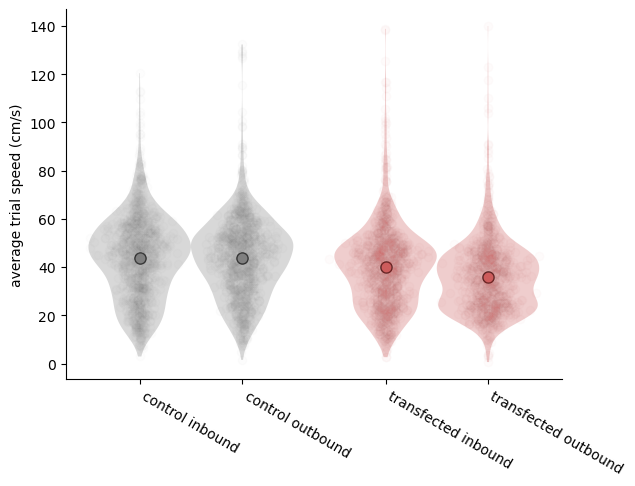

In [55]:
from Analysis.utils import violin_scatter
from scipy.stats import ttest_ind

root_condition = (opto_trial) + ~opto_trial  # & ~inbound_trial
root_condition = [True for _ in opto_trial]  # all trials
# root_condition = ~accuracy

fig = plt.figure()
ax = fig.add_subplot(111)


dur_stationary_list = []
label_locs = []
labels = []
label_locs = []
for j, (trial_type, type_name) in enumerate(
    zip(
        [inbound_trial, ~inbound_trial],
        ["inbound", "outbound"],
    )
):

    base_condition = root_condition & trial_type

    for i, (filter, color, group) in enumerate(
        zip(
            [transfected_trial, ~transfected_trial],
            transfection_style.values(),
            ["transfected", "control"],
        )
    ):
        condition = base_condition & filter
        dist = []

        for ii in np.where(condition)[0]:
            velocity = np.array(trial_velocities[ii])
            velocity = velocity[~np.isnan(velocity)][::20]
            # dist.extend(velocity)
            dist.append(np.nanmean(velocity))
        dist = np.array(dist)
        dist = dist[np.isfinite(dist)]
        # dist = np.log10(np.clip(dist, 1e-20, 1e3))
        from Analysis.utils import violin_scatter

        xloc = -i * (1.2) + j / 2
        mid = np.mean(dist)
        plt.scatter(xloc, mid, c=color, edgecolors="k", s=50, lw=2)
        violin_scatter(dist, pos=xloc, color=color, mark_mean=True, ax=ax)
        label_locs.append(xloc)
        labels.append(f"{group} {type_name}")

plt.xticks(label_locs, labels, rotation=-30, ha="left")
plt.ylabel("average trial speed (cm/s)")
ax.spines[["top", "right"]].set_visible(False)
plt.rcParams["svg.fonttype"] = "none"
fig.savefig(
    "/home/sambray/Documents/MS_analysis_samsplaying/Figures_20241201/wtrack_trial_speed_dist.svg"
)

# Dev

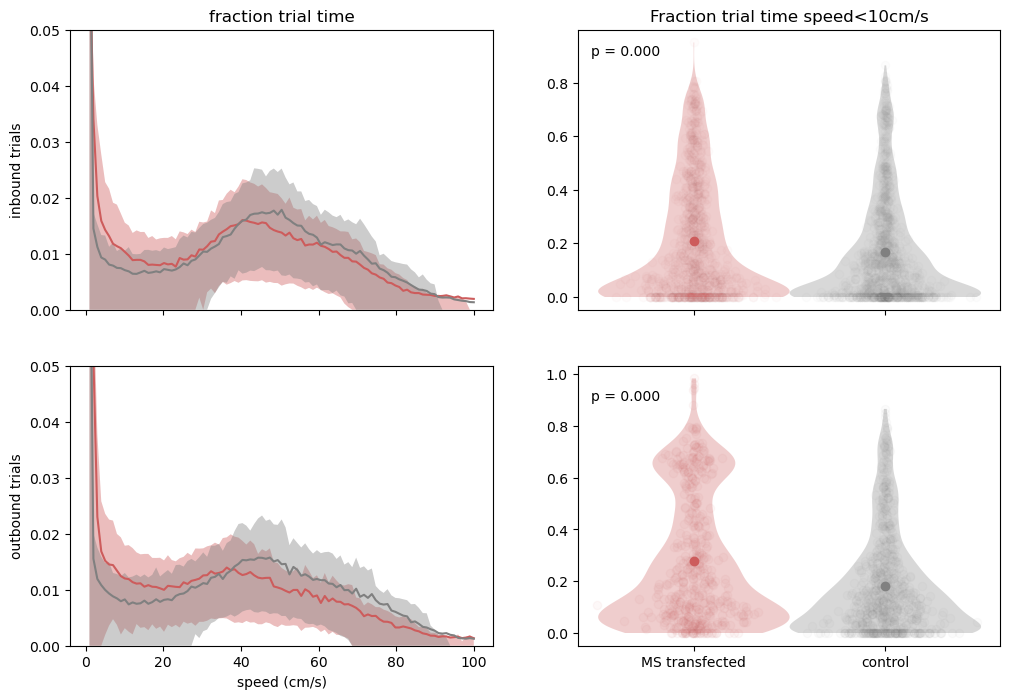

In [56]:
from Analysis.utils import violin_scatter
from scipy.stats import ttest_ind

root_condition = (opto_trial) + ~opto_trial  # & ~inbound_trial
root_condition = [True for _ in opto_trial]
root_condition = accuracy
speed_thresh = 10


fig, ax_list = plt.subplots(ncols=2, nrows=2, figsize=(12, 8), sharex="col")
for ii, trial_type in enumerate([inbound_trial, ~inbound_trial]):
    base_condition = root_condition & trial_type
    ax = ax_list[ii]
    stationary_list = []
    for i, (filter, color) in enumerate(
        zip([transfected_trial, ~transfected_trial], transfection_style.values())
    ):
        condition = base_condition & filter
        dist = []
        # for velocity in np.array(trial_velocities)[np.where(condition)[0]]:
        for ii in np.where(condition)[0]:
            velocity = np.array(trial_velocities[ii])
            velocity = velocity[~np.isnan(velocity)]
            val, bins = np.histogram(velocity, bins=np.linspace(0, 100, 100))
            if not val.sum():
                continue
            val = val / val.sum()
            dist.append(val)
        dist = np.array(dist)
        ax[0].plot(bins[1:], np.mean(dist, axis=0), c=color)
        ax[0].fill_between(
            bins[1:],
            np.nanpercentile(dist, 25, axis=0),
            np.nanpercentile(dist, 75, axis=0),
            facecolor=color,
            alpha=0.4,
        )
        # stationary time
        ind_stationary = np.where(bins < speed_thresh)[0]

        stationary_fract = np.nansum(dist[:, ind_stationary], axis=1)
        stationary_list.append(stationary_fract)
        violin_scatter(
            stationary_fract, pos=i / 2, ax=ax[1], color=color, bw_method=0.2
        )
        # violin = ax[1].violinplot(stationary_fract,positions=[i/2],
        #            showmedians=False,showextrema=False,points=1000,)
        # for pc in violin['bodies']:
        #     pc.set_facecolor(color)
        #     pc.set_alpha(.5)
        ax[1].scatter(
            [i / 2],
            np.mean(stationary_fract),
            color=color,
        )
        # break
    p_val = ttest_ind(stationary_list[0], stationary_list[1])[1]
    ax[1].text(-0.27, 0.9, f"p = {p_val:.3f}")
ax_list[
    0,
    0,
].set_ylim(0, 0.05)
ax_list[
    1,
    0,
].set_ylim(0, 0.05)
ax[0].set_xlabel("speed (cm/s)")
ax_list[0, 0].set_title("fraction trial time")
ax[1].set_xticks([0.0, 0.5])
ax[1].set_xticklabels(["MS transfected", "control"])
ax_list[0, 1].set_title(f"Fraction trial time speed<{speed_thresh}cm/s")

ax_list[0, 0].set_ylabel("inbound trials")
ax_list[1, 0].set_ylabel("outbound trials")

plt.rcParams["svg.fonttype"] = "none"
# fig.savefig("/home/sambray/Documents/MS_analysis_samsplaying/Plots/fens_2024/velocity_distribution_accurate.svg")
# fig.savefig(
#     "/home/sambray/Documents/MS_analysis_samsplaying/Figures_20241201/wtrack_speed_dist.svg"
# )